# NLP – Parte I: Classificação de Categoria de Transações a partir da *Descrição* da Fatura

**Objetivo:** Classificar a coluna **Category** usando o texto da coluna **Descrição** (NLP).  
Notebook cobre: descrição do dataset, pré-processamento, Bag-of-Words/TF‑IDF, treino/teste, métricas (accuracy e F1) e análise qualitativa.

## 1) Importações

In [1]:
# %% 1) Imports
import pandas as pd
import numpy as np
import re
from unidecode import unidecode

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

RANDOM_STATE = 42
pd.set_option("display.max_colwidth", 200)

## 2) Leitura do dataset

In [14]:
CSV_PATH = "fatura_cartao_credito_simulada_aug.csv"
df = pd.read_csv(CSV_PATH)

text_col = "description"
label_col = "category"

assert text_col in df.columns and label_col in df.columns, f"Colunas disponíveis: {list(df.columns)}"
print("Shape do dataset:", df.shape)
display(df.head())

Shape do dataset: (3400, 22)


,transaction_id,transaction_date,posting_date,description,merchant_name_clean,category,subcategory,amount_brl,currency,city,...,mcc,mcc_description,method,is_online,is_installment,installment_number,installment_total,card_last4,auth_code,status
0,TXAUG002869,2024-03-25,2024-03-26,transfer Air-Brasil,Air-Brasil,Viagem,Hospedagem,698.75,BRL,Porto Alegre,...,4511,Companhias aéreas,chip,True,False,NaN,NaN,6022,865115,pending
1,TXAUG002148,2025-07-31,2025-08-02,farmácia online,DROGA-RAIA,Saúde,Farmácia,367.20,BRL,São Paulo,...,5912,Farmácias,chip,False,False,NaN,NaN,6022,937644,pending
2,TXAUG000310,2024-02-13,2024-02-14,pl@no premium RJ,Premium Brasil,Assinaturas,Streaming Vídeo,22.59,BRL,Recife,...,4899,Assinaturas digitais,chip,True,False,NaN,NaN,6022,534232,posted
3,TXAUG002321,2024-12-09,2024-12-10,limpeza #5830,Oficina Mecânica,Serviços,Serviços automotivos,426.48,BRL,Florianópolis,...,8999,Serviços diversos,online,False,False,NaN,NaN,6022,488486,pending
4,TXAUG000503,2024-10-30,2024-11-02,salão #8069,Salon LTDA,Beleza,Cosméticos,338.40,BRL,Guarulhos,...,5977,Cosméticos e perfumaria,chip,False,False,NaN,NaN,6022,657159,pending


## 3) Descrição do conjunto de dados

Tarefa: Classificar a categoria da transação a partir do nome do estabelecimento (Merchant Name).
Nº documentos: 3400
Nº classes: 17


category
Viagem                    200
Eletrônicos               200
Estacionamento/Pedágio    200
Educação                  200
Casa                      200
Alimentação               200
Combustível               200
Vestuário                 200
Transporte                200
Saúde                     200
Reembolso                 200
Lazer                     200
Esportes                  200
Beleza                    200
Serviços                  200
Assinaturas               200
Mercado                   200
Name: count, dtype: int64

Tamanho dos textos (tokens) — min/med/max: 2 2.0 8


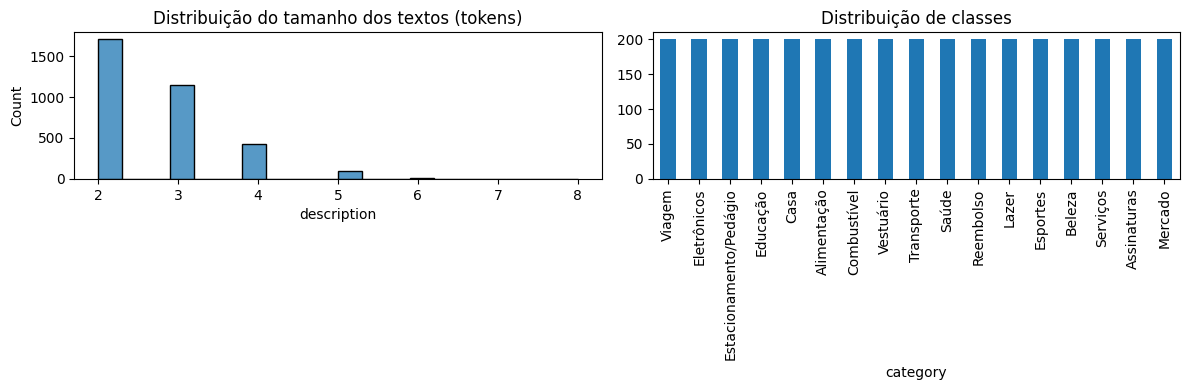

In [15]:
# %% Descrição
task = "Classificar a categoria da transação a partir do nome do estabelecimento (Merchant Name)."
print("Tarefa:", task)

df = df.dropna(subset=[text_col, label_col]).copy()

n_docs = len(df)
classes = df[label_col].unique()
n_classes = len(classes)
class_counts = df[label_col].value_counts()

print(f"Nº documentos: {n_docs}")
print(f"Nº classes: {n_classes}")
display(class_counts)

def simple_tokenize(s):
    s = unidecode(str(s)).lower()
    s = re.sub(r"[^0-9a-z ]+", " ", s)
    return [t for t in s.split() if t]

lengths = df[text_col].map(lambda s: len(simple_tokenize(s)))
print("Tamanho dos textos (tokens) — min/med/max:",
      int(lengths.min()), float(np.median(lengths)), int(lengths.max()))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(lengths, bins=20, ax=ax[0])
ax[0].set_title("Distribuição do tamanho dos textos (tokens)")
class_counts.plot(kind='bar', ax=ax[1])
ax[1].set_title("Distribuição de classes")
plt.tight_layout()
plt.show()

## 4) Pré-processamento
Aplicamos: unidecode, lowercase e remoção de caracteres não alfanuméricos.

In [16]:
# %% Preprocess
def preprocess_text(s: str) -> str:
    s = unidecode(str(s))
    s = s.lower()
    s = re.sub(r"[^0-9a-z ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text_clean"] = df[text_col].map(preprocess_text)
display(df[[text_col, "text_clean", label_col]].head())

,description,text_clean,category
0,transfer Air-Brasil,transfer air brasil,Viagem
1,farmácia online,farmacia online,Saúde
2,pl@no premium RJ,pl no premium rj,Assinaturas
3,limpeza #5830,limpeza 5830,Serviços
4,salão #8069,salao 8069,Beleza


## 5) Split treino/teste (estratificado)

In [17]:
# %% Split
X_train, X_test, y_train, y_test = train_test_split(
    df["text_clean"], df[label_col],
    test_size=0.2, random_state=RANDOM_STATE, stratify=df[label_col]
)
len(X_train), len(X_test)

(2720, 680)

## 6) Representações: Bag-of-Words e TF‑IDF

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# (A) BoW baseline
bow = CountVectorizer(min_df=3, strip_accents='unicode', token_pattern=r'(?u)\b\w+\b')

# (B) TF-IDF 
tfidf_word = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,              # filtra termos super comuns
    sublinear_tf=True,       # tf log(1+tf)
    strip_accents='unicode'
)

# (C) TF-IDF de caracteres
tfidf_char = TfidfVectorizer(
    analyzer='char_wb',      
    ngram_range=(3, 5),
    min_df=5,               
    strip_accents='unicode'
)

# Fit no TREINO e transform no TESTE
Xtr_bow  = bow.fit_transform(X_train);   Xte_bow  = bow.transform(X_test)
Xtr_w    = tfidf_word.fit_transform(X_train); Xte_w    = tfidf_word.transform(X_test)
Xtr_char = tfidf_char.fit_transform(X_train); Xte_char = tfidf_char.transform(X_test)

print("BoW:", Xtr_bow.shape, " | TF-IDF(word):", Xtr_w.shape, " | TF-IDF(char):", Xtr_char.shape)

BoW: (2720, 316)  | TF-IDF(word): (2720, 953)  | TF-IDF(char): (2720, 3278)


In [19]:
feat = bow.get_feature_names_out()                           # termos na ordem das colunas
tf_total = np.asarray(Xtr_bow.sum(axis=0)).ravel()           # soma das contagens por termo
doc_freq = np.asarray((Xtr_bow > 0).sum(axis=0)).ravel()     # em quantos docs o termo aparece

vocab_stats = pd.DataFrame({
    "term": feat,
    "tf_total": tf_total,
    "doc_freq": doc_freq,
}).sort_values("tf_total", ascending=False)

vocab_stats.head(20)   # Top 20 por frequência total

,term,tf_total,doc_freq
210,online,452,452
75,compra,375,371
88,de,217,216
63,center,95,94
66,cia,74,74
272,shop,72,72
46,brasil,65,65
190,mensalidade,64,64
175,ltda,61,61
269,servico,59,59


## 7) Classificadores e avaliação

In [20]:
# %% Models & evaluation
def evaluate_model(clf, Xtr, ytr, Xte, yte, name="model"):
    clf.fit(Xtr, ytr)
    ytr_pred = clf.predict(Xtr)
    yte_pred = clf.predict(Xte)

    acc_tr = accuracy_score(ytr, ytr_pred)
    acc_te = accuracy_score(yte, yte_pred)
    f1_tr = f1_score(ytr, ytr_pred, average="macro")
    f1_te = f1_score(yte, yte_pred, average="macro")

    print(f"\n=== {name} ===")
    print(f"Train  | Acc: {acc_tr:.3f} | F1-macro: {f1_tr:.3f}")
    print(f"Test   | Acc: {acc_te:.3f} | F1-macro: {f1_te:.3f}")
    print("\nRelatório por classe (TEST):")
    print(classification_report(yte, yte_pred, digits=3))
    return {"name": name, "acc_tr": acc_tr, "acc_te": acc_te, "f1_tr": f1_tr, "f1_te": f1_te}

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB

models = [
    ("LinearSVC C=0.5", LinearSVC(C=0.5)),
    ("LogReg C=0.5",    LogisticRegression(C=0.5, solver="liblinear", max_iter=300, multi_class="ovr")),
    ("ComplementNB a=0.5", ComplementNB(alpha=0.5)),
]

# Avalie BoW
results_bow = []
for name, clf in models:
    results_bow.append(evaluate_model(clf, Xtr_bow, y_train, Xte_bow, y_test, name=f"{name} + BoW"))

# Avalie TF-IDF de PALAVRAS (1–2)
results_w = []
for name, clf in models:
    results_w.append(evaluate_model(clf, Xtr_w, y_train, Xte_w, y_test, name=f"{name} + TFIDF(word)"))

# Avalie TF-IDF de CARACTERES (3–5) — <== geralmente o melhor neste dataset
results_char = []
for name, clf in models:
    results_char.append(evaluate_model(clf, Xtr_char, y_train, Xte_char, y_test, name=f"{name} + TFIDF(char)"))



=== LinearSVC C=0.5 + BoW ===
Train  | Acc: 0.990 | F1-macro: 0.990
Test   | Acc: 0.963 | F1-macro: 0.963

Relatório por classe (TEST):
                        precision    recall  f1-score   support

           Alimentação      0.923     0.900     0.911        40
           Assinaturas      0.927     0.950     0.938        40
                Beleza      0.907     0.975     0.940        40
                  Casa      1.000     0.950     0.974        40
           Combustível      0.976     1.000     0.988        40
              Educação      0.925     0.925     0.925        40
           Eletrônicos      0.925     0.925     0.925        40
              Esportes      1.000     1.000     1.000        40
Estacionamento/Pedágio      0.976     1.000     0.988        40
                 Lazer      1.000     0.975     0.987        40
               Mercado      0.952     1.000     0.976        40
             Reembolso      0.947     0.900     0.923        40
                 Saúde      0.

C:\Users\Usuário\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Usuário\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogReg C=0.5 + TFIDF(word) ===
Train  | Acc: 0.990 | F1-macro: 0.990
Test   | Acc: 0.971 | F1-macro: 0.971

Relatório por classe (TEST):
                        precision    recall  f1-score   support

           Alimentação      0.884     0.950     0.916        40
           Assinaturas      0.909     1.000     0.952        40
                Beleza      0.909     1.000     0.952        40
                  Casa      1.000     1.000     1.000        40
           Combustível      1.000     1.000     1.000        40
              Educação      1.000     0.900     0.947        40
           Eletrônicos      0.974     0.925     0.949        40
              Esportes      1.000     1.000     1.000        40
Estacionamento/Pedágio      0.952     1.000     0.976        40
                 Lazer      1.000     0.975     0.987        40
               Mercado      0.952     1.000     0.976        40
             Reembolso      1.000     0.900     0.947        40
                 Saúde   

C:\Users\Usuário\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


## 8) Comparação resumida

In [21]:
# %% Summary
res_df = pd.DataFrame(results_bow + results_w + results_char)
display(res_df.sort_values("f1_te", ascending=False).reset_index(drop=True))

,name,acc_tr,acc_te,f1_tr,f1_te
0,LinearSVC C=0.5 + TFIDF(char),0.995956,0.986765,0.995943,0.986645
1,LogReg C=0.5 + TFIDF(char),0.990809,0.979412,0.990779,0.979452
2,ComplementNB a=0.5 + TFIDF(char),0.988235,0.979412,0.988175,0.979226
3,ComplementNB a=0.5 + TFIDF(word),0.989338,0.972059,0.989333,0.971933
4,LogReg C=0.5 + TFIDF(word),0.990074,0.970588,0.990060,0.970618
5,LinearSVC C=0.5 + TFIDF(word),0.993015,0.969118,0.993019,0.969022
6,LogReg C=0.5 + BoW,0.985662,0.963235,0.985705,0.963222
7,LinearSVC C=0.5 + BoW,0.989706,0.963235,0.989724,0.963186
8,ComplementNB a=0.5 + BoW,0.978676,0.961765,0.978733,0.961710


## 9) Análise qualitativa – erros do melhor modelo

Melhor modelo: LinearSVC C=0.5 + TFIDF(char)
Total de erros: 9


,text,true,pred,conf
2844,aliexpress 10c3,Reembolso,Eletrônicos,0.446169
677,estapar curitiba,Reembolso,Estacionamento/Pedágio,0.383188
2906,o boticario belo horizonte,Reembolso,Beleza,0.282910
2457,mensalidade 7070,Assinaturas,Educação,0.228522
1627,mensalidade 6223,Assinaturas,Educação,0.225678
1018,mensalidade rj,Educação,Assinaturas,0.222299
991,mensalidade online,Assinaturas,Educação,0.214831
2147,outback c29 recif,Reembolso,Alimentação,0.207678
877,natura sao paulo,Beleza,Reembolso,0.102387


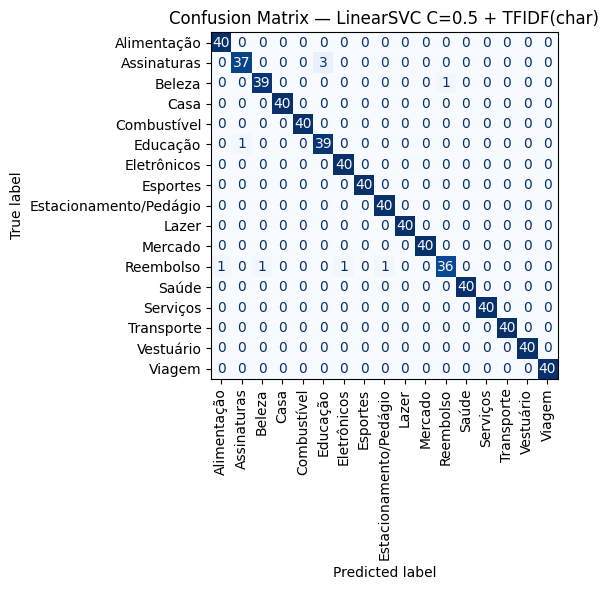


Classe: Alimentação
Top +: ['padar', 'abib', ' habi', 'abi', ' hab', 'bib', 'habi', 'hab', ' ha', 'habib', 'ntar', 'ntar ', 'tar ', ' if', 'ant']

Classe: Assinaturas
Top +: [' stre', 'ssin', 'ssi', 'inatu', 'inat', 'ssina', 'sin', 'sinat', 'sina', 'eno', 'renov', 'enov', ' reno', 'nov', 'reno']

Classe: Beleza
Top +: ['tacao', ' hid', 'idr', ' hidr', 'hid', 'bea', ' sala', 'lao ', 'sala', 'alao ', 'alao', 'lao', 'salao', ' sal', 'cos']

Classe: Casa
Top +: [' deco', 'decor', 'deco', 'eco', 'ecor', 'cas', 'as ', 'me ', ' home', 'home', 'home ', ' hom', 'ome ', 'hom', 'ome']

Classe: Combustível
Top +: ['ost', 'osto', 'post', ' pos', 'ell ', 'shell', 'hel', 'hell', 'hell ', ' shel', 'shel', 'ell', ' et', 'nol', 'nol ']

Classe: Educação
Top +: [' cu', ' li', 'liv', 'urs', 'ivr', 'livr', 'rso ', 'curso', 'curs', ' curs', 'urso', 'urso ', 'rso', ' livr', ' liv']

Classe: Eletrônicos
Top +: ['ouse', 'mou', 'use ', 'mous', 'ecl', 'tecl', ' tecl', 'ast', ' tec', 'st ', 'gad', ' fast', 'ast 

In [25]:
# ## 9) Análise qualitativa – erros do melhor modelo (ajustado p/ BoW, TFIDF(word), TFIDF(char))

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_name = res_df.sort_values("f1_te", ascending=False).iloc[0]["name"]
print("Melhor modelo:", best_name)

# --- 1) Descobrir vetorizaror correto a partir do nome ---
def pick_vectorizer(best_name):
    # Ajuste aqui os nomes se você usou outros rótulos no res_df
    if "TFIDF(char)" in best_name:
        return tfidf_char
    if "TFIDF(word)" in best_name:
        return tfidf_word
    if "BoW" in best_name:
        return bow
    if "TF-IDF" in best_name:  # fallback p/ nome antigo
        return tfidf
    raise ValueError(f"Não reconheço o vetorizaror de: {best_name}")

# --- 2) Descobrir classificador correto a partir do nome ---
def pick_classifier(best_name):
    base = best_name.split(" + ")[0].strip()
    if base.startswith("LinearSVC"):
        # tentar extrair C=... se presente
        import re
        m = re.search(r"C=([\d\.]+)", base)
        C = float(m.group(1)) if m else 1.0
        return LinearSVC(C=C)
    if base.startswith("LogReg"):
        import re
        m = re.search(r"C=([\d\.]+)", base)
        C = float(m.group(1)) if m else 1.0
        return LogisticRegression(C=C, solver="liblinear", max_iter=300, multi_class="ovr")
    if base.startswith("ComplementNB"):
        import re
        m = re.search(r"a=([\d\.]+)", base)
        alpha = float(m.group(1)) if m else 1.0
        return ComplementNB(alpha=alpha)
    # Fallbacks antigos:
    if base == "LinearSVC": return LinearSVC()
    if base.startswith("LogReg"): return LogisticRegression(solver="liblinear", max_iter=300, multi_class="ovr")
    raise ValueError(f"Não reconheço o classificador de: {best_name}")

vec = pick_vectorizer(best_name)
clf = pick_classifier(best_name)

# --- 3) Re-treinar no TREINO com esse pipeline e prever no TESTE ---
Xtr = vec.fit_transform(X_train)
Xte = vec.transform(X_test)
clf.fit(Xtr, y_train)
y_pred = clf.predict(Xte)

# --- 4) Confiança da predição (quando disponível) ---
def pred_confidence(clf, X):
    # LogisticRegression / ComplementNB: usa predict_proba
    if hasattr(clf, "predict_proba"):
        p = clf.predict_proba(X)
        return p.max(axis=1)
    # LinearSVC: usa decision_function (margem); normalizamos para [0,1] p/ ordenar
    if hasattr(clf, "decision_function"):
        df = clf.decision_function(X)
        if df.ndim == 1:  # binário
            # converter para 2 colunas margin-based
            df = np.vstack([-df, df]).T
        m = df.max(axis=1)
        # escala min-max só para fins de ordenação/inspeção
        mm = (m - m.min()) / (m.max() - m.min() + 1e-9)
        return mm
    return np.zeros(X.shape[0])

conf = pred_confidence(clf, Xte)

# --- 5) Tabela de erros, ordenada por confiança (maior piores) ---
errors = X_test.to_frame(name="text").copy()
errors["true"] = y_test.values
errors["pred"] = y_pred
errors["conf"] = conf
errors = errors[errors["true"] != errors["pred"]].sort_values("conf", ascending=False)

print(f"Total de erros: {len(errors)}")
display(errors.head(20))

# --- 6) (Opcional) Matriz de confusão do melhor modelo ---
fig, ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=90, ax=ax, cmap="Blues", colorbar=False)
ax.set_title(f"Confusion Matrix — {best_name}")
plt.tight_layout()
plt.show()

# --- 7) (Opcional) Top n-grams mais informativos por classe ---
def show_top_features(clf, vec, topn=15):
    terms = np.array(getattr(vec, "get_feature_names_out")())
    if isinstance(clf, (LinearSVC,)):
        # OvR: coef_[classe] > 0 indica evidência pró-classe
        for i, cls in enumerate(clf.classes_):
            coefs = clf.coef_[i]
            top_pos = np.argsort(coefs)[-topn:]
            print(f"\nClasse: {cls}")
            print("Top +:", list(terms[top_pos]))
    elif isinstance(clf, LogisticRegression):
        for i, cls in enumerate(clf.classes_):
            coefs = clf.coef_[i]
            top_pos = np.argsort(coefs)[-topn:]
            print(f"\nClasse: {cls}")
            print("Top +:", list(terms[top_pos]))
    elif isinstance(clf, ComplementNB):
        # features com maior log-prob em cada classe
        for i, cls in enumerate(clf.classes_):
            top_pos = np.argsort(clf.feature_log_prob_[i])[-topn:]
            print(f"\nClasse: {cls}")
            print("Top +:", list(terms[top_pos]))
    else:
        print("Top features não suportado para este classificador.")

show_top_features(clf, vec, topn=15)

## Predição com Fatura real

In [ ]:
from pathlib import Path

CSV_FATURA = "saida.csv"

# 1) Ler CSV (tenta detectar o separador automaticamente)
try:
    fatura = pd.read_csv(CSV_FATURA, sep=None, engine="python")
except Exception:
    fatura = pd.read_csv(CSV_FATURA, sep=";")

# 2) Escolher a coluna de texto
candidatas = ["Descrição"]
text_col = None
for c in candidatas:
    if c in fatura.columns:
        text_col = c; break
if text_col is None:
    raise ValueError(f"Não encontrei coluna de texto. Colunas do CSV: {list(fatura.columns)}")

# 3) Pré-processamento igual ao do treino
def preprocess_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[^0-9a-zà-ÿ ]+", " ", s)  # mantém acentos
    s = re.sub(r"\s+", " ", s).strip()
    return s

fatura["text_clean"] = fatura[text_col].astype(str).map(preprocess_text)

# 4) Transformar com o MESMO vetorizar e prever com o MESMO classificador
#   vec = tfidf_char   (ou tfidf_word / bow)
#   clf = LinearSVC(C=0.5) treinado (ou LogReg / ComplementNB) 
X_new = vec.transform(fatura["text_clean"])
y_pred = clf.predict(X_new)

# 5) Confiança (proba ou margem normalizada)
def predict_confidence(clf, X):
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X).max(axis=1)
    if hasattr(clf, "decision_function"):
        d = clf.decision_function(X)
        if d.ndim == 1:
            d = np.vstack([-d, d]).T
        m = d.max(axis=1)
        return (m - m.min())/(m.max()-m.min() + 1e-9)
    return np.zeros(X.shape[0])

fatura["pred_category"]   = y_pred
fatura["pred_confidence"] = predict_confidence(clf, X_new)

# 7) Salvar e pré-visualizar
OUT = Path("fatura_predita.csv")
fatura.to_csv(OUT, index=False)
print("Salvo em:", OUT.resolve())
fatura[[text_col, "pred_category", "pred_confidence"]].sort_values("pred_confidence", ascending=False).head(5)


Salvo em: C:\Users\Usuário\Documents\pos-ia-cd\NLP\fatura_predita.csv


,Descrição,pred_category,pred_confidence
29,DROGASIL3387,Saúde,1.000000
0,RESTAURANTEFRIGI,Alimentação,0.780369
15,EBN *SPOTIFY,Assinaturas,0.757791
28,MERCADOPAGO*FAZTICKET,Mercado,0.651428
39,MERCADOPAGO*COMBODOREI,Mercado,0.613553


In [ ]:
fatura[[text_col, "pred_category", "pred_confidence"]].sort_values("pred_confidence", ascending=True).head(5)

,Descrição,pred_category,pred_confidence
34,WINDSURF,Eletrônicos,0.000000
6,EC*SAMSUNG,Casa,0.016920
2,ANUIDADEDIFERENCIADA,Viagem,0.017495
13,CIRNEIRMAOSCIALTDA,Saúde,0.017844
8,AGUIABRANCA-P,Beleza,0.052002
